# Image segmentation for [set-lipstick-original dataset](https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/)

In [1]:
import time
import os
from glob import glob

import numpy as np 
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score as jsc

from matplotlib import pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

## Read and preprocess data

In [2]:
df = pd.read_csv('data\list.csv')
df

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png
...,...,...,...,...,...,...,...,...,...
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png


In [3]:
df['height'].unique()

array([720, 675], dtype=int64)

In [4]:
# define some settings
epochs = 10

img_fp = 'data/720p'
masks_fp = 'data/mask'

In [5]:
masks = glob(masks_fp+'/*')
images = glob(img_fp+'/*')

# there is a mismatch between real images and masks
len(images), len(masks)

(28594, 28540)

In [6]:
# add relative path to images and masks
df['filename'] = img_fp + '/' + df['filename'].astype(str)
df['mask'] = masks_fp + '/' + df['mask'].astype(str)

In [7]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,data/720p/image00000001.jpg,1280,720,Lips,661,394,776,444,data/mask/mask00000001.png
1,data/720p/image00000002.jpg,1280,720,Lips,557,336,682,392,data/mask/mask00000002.png
2,data/720p/image00000003.jpg,1280,720,Lips,553,369,684,427,data/mask/mask00000003.png
3,data/720p/image00000004.jpg,1280,720,Lips,555,351,681,408,data/mask/mask00000004.png
4,data/720p/image00000005.jpg,1280,720,Lips,555,351,680,407,data/mask/mask00000005.png


In [8]:
# delete rows if real images not found for it
idx_to_drop = []

for idx in df.index:
    cur_row = df.iloc[idx]
    if not os.path.exists(cur_row['filename']) or not os.path.exists(cur_row['mask']):
        # list_df = list_df.drop(idx, axis=0)
        idx_to_drop.append(idx)
        
print(f"Search done, rows to remove: {len(idx_to_drop)}")

Search done, rows to remove: 54


In [9]:
df = df.drop(idx_to_drop, axis=0)
df = df[['filename', 'mask']]
df = df.reset_index(drop=True)

In [10]:
df.shape

(28540, 2)

In [11]:
df.head()

,filename,mask
0,data/720p/image00000001.jpg,data/mask/mask00000001.png
1,data/720p/image00000002.jpg,data/mask/mask00000002.png
2,data/720p/image00000003.jpg,data/mask/mask00000003.png
3,data/720p/image00000004.jpg,data/mask/mask00000004.png
4,data/720p/image00000005.jpg,data/mask/mask00000005.png


In [12]:
# adopted from class notebook

class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера XxY float-значений
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (x, y, 3) -> (1, x, y, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, x, y, 3) -> (1, 3, x, y)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с XxY на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера XY float-значений
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 2 каналов масками нужных классов
        # 1, если принадлежит классу, 0 если не принадлежит 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 2):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
                
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len
    
    
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = logits
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =(2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        #print(score.sum())
        score =1 - score.sum() / num
        return score

In [20]:
# split dataset image paths
X_train, X_test = train_test_split(df, test_size=0.3)

# reset indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [21]:
# wrap up with torch dataset
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

train_data_loader = DataLoader(train_data, batch_size=128,shuffle=True)
test_data_loader = DataLoader(train_data, batch_size=128,shuffle=False)

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [23]:
# create model
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device) # se_resnet101

In [24]:
optimizer = torch.optim.Adam(segmodel.parameters())

In [27]:
criterion = SoftDiceLoss()

In [29]:
%%time

epoch_losses = []
for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        print(f'batch index : {i} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

C:\Users\Nickel\anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


batch index : 0 | loss : 0.4686161279678345
batch index : 1 | loss : 0.3071622848510742
batch index : 2 | loss : 0.36870336532592773
batch index : 3 | loss : 0.2993308901786804
batch index : 4 | loss : 0.19795870780944824
batch index : 5 | loss : 0.07155531644821167
batch index : 6 | loss : 0.04137539863586426
batch index : 7 | loss : 0.11171424388885498
batch index : 8 | loss : 0.2219374179840088
batch index : 9 | loss : -0.052559852600097656
batch index : 10 | loss : 0.06206715106964111
batch index : 11 | loss : 0.04565197229385376
batch index : 12 | loss : -0.20890676975250244
batch index : 13 | loss : -0.23346519470214844
batch index : 14 | loss : -0.3938620090484619
batch index : 15 | loss : -0.36261510848999023
batch index : 16 | loss : -0.4848790168762207
batch index : 17 | loss : -0.47525954246520996
batch index : 18 | loss : -0.32287323474884033
batch index : 19 | loss : -0.44463610649108887
batch index : 20 | loss : -0.4322526454925537
batch index : 21 | loss : -0.55860090255

batch index : 19 | loss : -0.7949991226196289
batch index : 20 | loss : -0.8965154886245728
batch index : 21 | loss : -0.8569366931915283
batch index : 22 | loss : -0.8064165115356445
batch index : 23 | loss : -0.8070361614227295
batch index : 24 | loss : -0.9277632236480713
batch index : 25 | loss : -0.9096629619598389
batch index : 26 | loss : -0.7600924968719482
batch index : 27 | loss : -0.7421489953994751
batch index : 28 | loss : -0.7684590816497803
batch index : 29 | loss : -0.6422138214111328
batch index : 30 | loss : -0.8750712871551514
batch index : 31 | loss : -0.8816254138946533
batch index : 32 | loss : -0.8834569454193115
batch index : 33 | loss : -0.8725171089172363
batch index : 34 | loss : -0.9062604904174805
batch index : 35 | loss : -0.854002833366394
batch index : 36 | loss : -0.8912003040313721
batch index : 37 | loss : -0.882512092590332
batch index : 38 | loss : -0.8455460071563721
batch index : 39 | loss : -0.8978699445724487
batch index : 40 | loss : -0.8559455

In [43]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.cpu().numpy()
    image = np.clip(image, 0, 1)
    return image

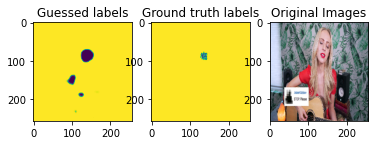

<ipython-input-44-417956fa7e4c>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

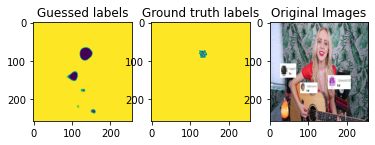

<Figure size 432x288 with 0 Axes>

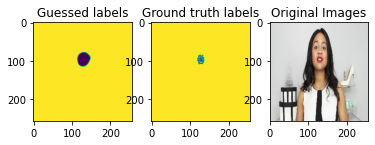

<Figure size 432x288 with 0 Axes>

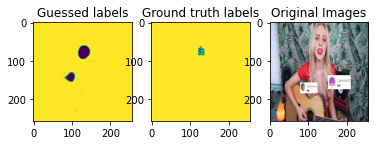

<Figure size 432x288 with 0 Axes>

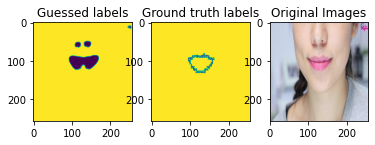

<Figure size 432x288 with 0 Axes>

In [44]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs = segmodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs.detach().cpu().numpy()[0,0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    original = get_orig(images[0][0,:,:,:])
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    
    plt.show()
    plt.gcf().show()
    if i>3:
        break